**Apple:**          2,737<br>
**Asparagus:**      2,159<br>
**Banana:**         2,501<br>
**Broccoli:**       1,996<br>
**Cabbage:**       2,194<br>
**Capsicums:**      1,980<br>
**Cherry:**         2,414<br>
**Cherry Tomato:**  2,553<br>
**Chilli:**         2,488<br>
**Grapes:**         3,525<br>
**Mango:**         2,752<br>
**Pakchoi:**        2,689<br>
**Soursop:**        2,146<br>
**Spinach:**        2,055<br>
**Strawberry:**     2,845<br>

**Total:** 37,034

In [2]:
# Importing the Keras libraries and packages
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Importing other necessary libraries
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import h5py, os, itertools, heapq

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
input_shape = (128, 128, 3)
num_classes = 15

model = Sequential()

model.add(Convolution2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

In [ ]:
# Viewing model_configuration

model.summary()

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 40,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validate_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('./Model/Train',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validate_set = validate_datagen.flow_from_directory('./Model/Validate',
                                                    target_size = (128, 128),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')

In [ ]:
checkpointer = ModelCheckpoint(filepath='model_base.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

filename='model_train_new.csv'
csv_log = CSVLogger(filename, separator=',', append=False)

In [ ]:
hist = model.fit_generator(training_set,
                           steps_per_epoch = (27442//32),
                           epochs = 50,
                           validation_data = validate_set,
                           validation_steps = (6809//32), 
                           workers = 4, 
                           callbacks = [csv_log,checkpointer,EarlyStopping(monitor='val_loss', patience=10)])

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['acc'],'r',linewidth=3.0)
plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
# test_image = load_img('./Model/Test/apple/apple_126.jpg', target_size = (128, 128))
# test_image = img_to_array(test_image)/255
# test_image = np.expand_dims(test_image, axis = 0)
# print(test_image.shape)
# # Predicting the test image
# print(loaded_model.predict(test_image))
# print(loaded_model.predict_classes(test_image))

### Model Evaluation

In [3]:
# Loading the best model
loaded_model = load_model('./Results/model_base.45-0.80.hdf5')

In [4]:
num_classes = 15
test_dir = './Model/Test/'

test_list=[]

for category in os.listdir(test_dir):
    image_list =os.listdir(test_dir + category)
    print ('Loaded images of dataset-'+'{}'.format(category))
    for img in image_list:
        test_image = load_img(test_dir + category + '/' + img, target_size = (128, 128))
        test_image = img_to_array(test_image)/255
        test_image = np.expand_dims(test_image, axis = 0)
        test_list.append(test_image)

test_data = np.array(test_list)
test_data = test_data.astype('float32')
print (test_data.shape)

Loaded images of dataset-apple
Loaded images of dataset-asparagus
Loaded images of dataset-banana
Loaded images of dataset-broccoli
Loaded images of dataset-cabbage
Loaded images of dataset-capsicums
Loaded images of dataset-cherry
Loaded images of dataset-cherry_tomato
Loaded images of dataset-chilli
Loaded images of dataset-grapes
Loaded images of dataset-mango
Loaded images of dataset-pakchoi
Loaded images of dataset-soursop
Loaded images of dataset-spinach
Loaded images of dataset-strawberry
(1858, 1, 128, 128, 3)


In [5]:
img_count_incat = []
img_count_incat_cumulative = []
for category in os.listdir(test_dir):
    path, dirs, files = next(os.walk(test_dir + category))
    img_count = len(files)
    img_count_incat.append(img_count)
    img_count_incat_cumulative.append(np.sum(img_count_incat))

In [6]:
num_of_samples = test_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

for i in range(num_classes):
    if i == 0:
        labels[0:img_count_incat_cumulative[i]] = i
    else:
        labels[img_count_incat_cumulative[i-1]:img_count_incat_cumulative[i]] = i

target_names = ['Apple', 'Asparagus', 'Banana', 'Broccoli', 'Cabbage', 
                'Capsicums', 'Cherry', 'Cherry Tomato', 'Chilli', 'Grapes', 
                'Mango', 'Pakchoi', 'Soursop', 'Spinach', 'Strawberry']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

In [7]:
def predictor(test_data, model):
    predictions = []
    for i in range(len(test_data)):
        result = model.predict_classes(test_data[i])
        predictions.append(int(result))
    
    return predictions

In [8]:
# Plotting the confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    Function plots a confusion matrix

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label\n\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass), fontsize=15)
    plt.show()

In [9]:
true_labels = np.argmax(Y, axis = 1)
predictions = predictor(test_data, loaded_model)

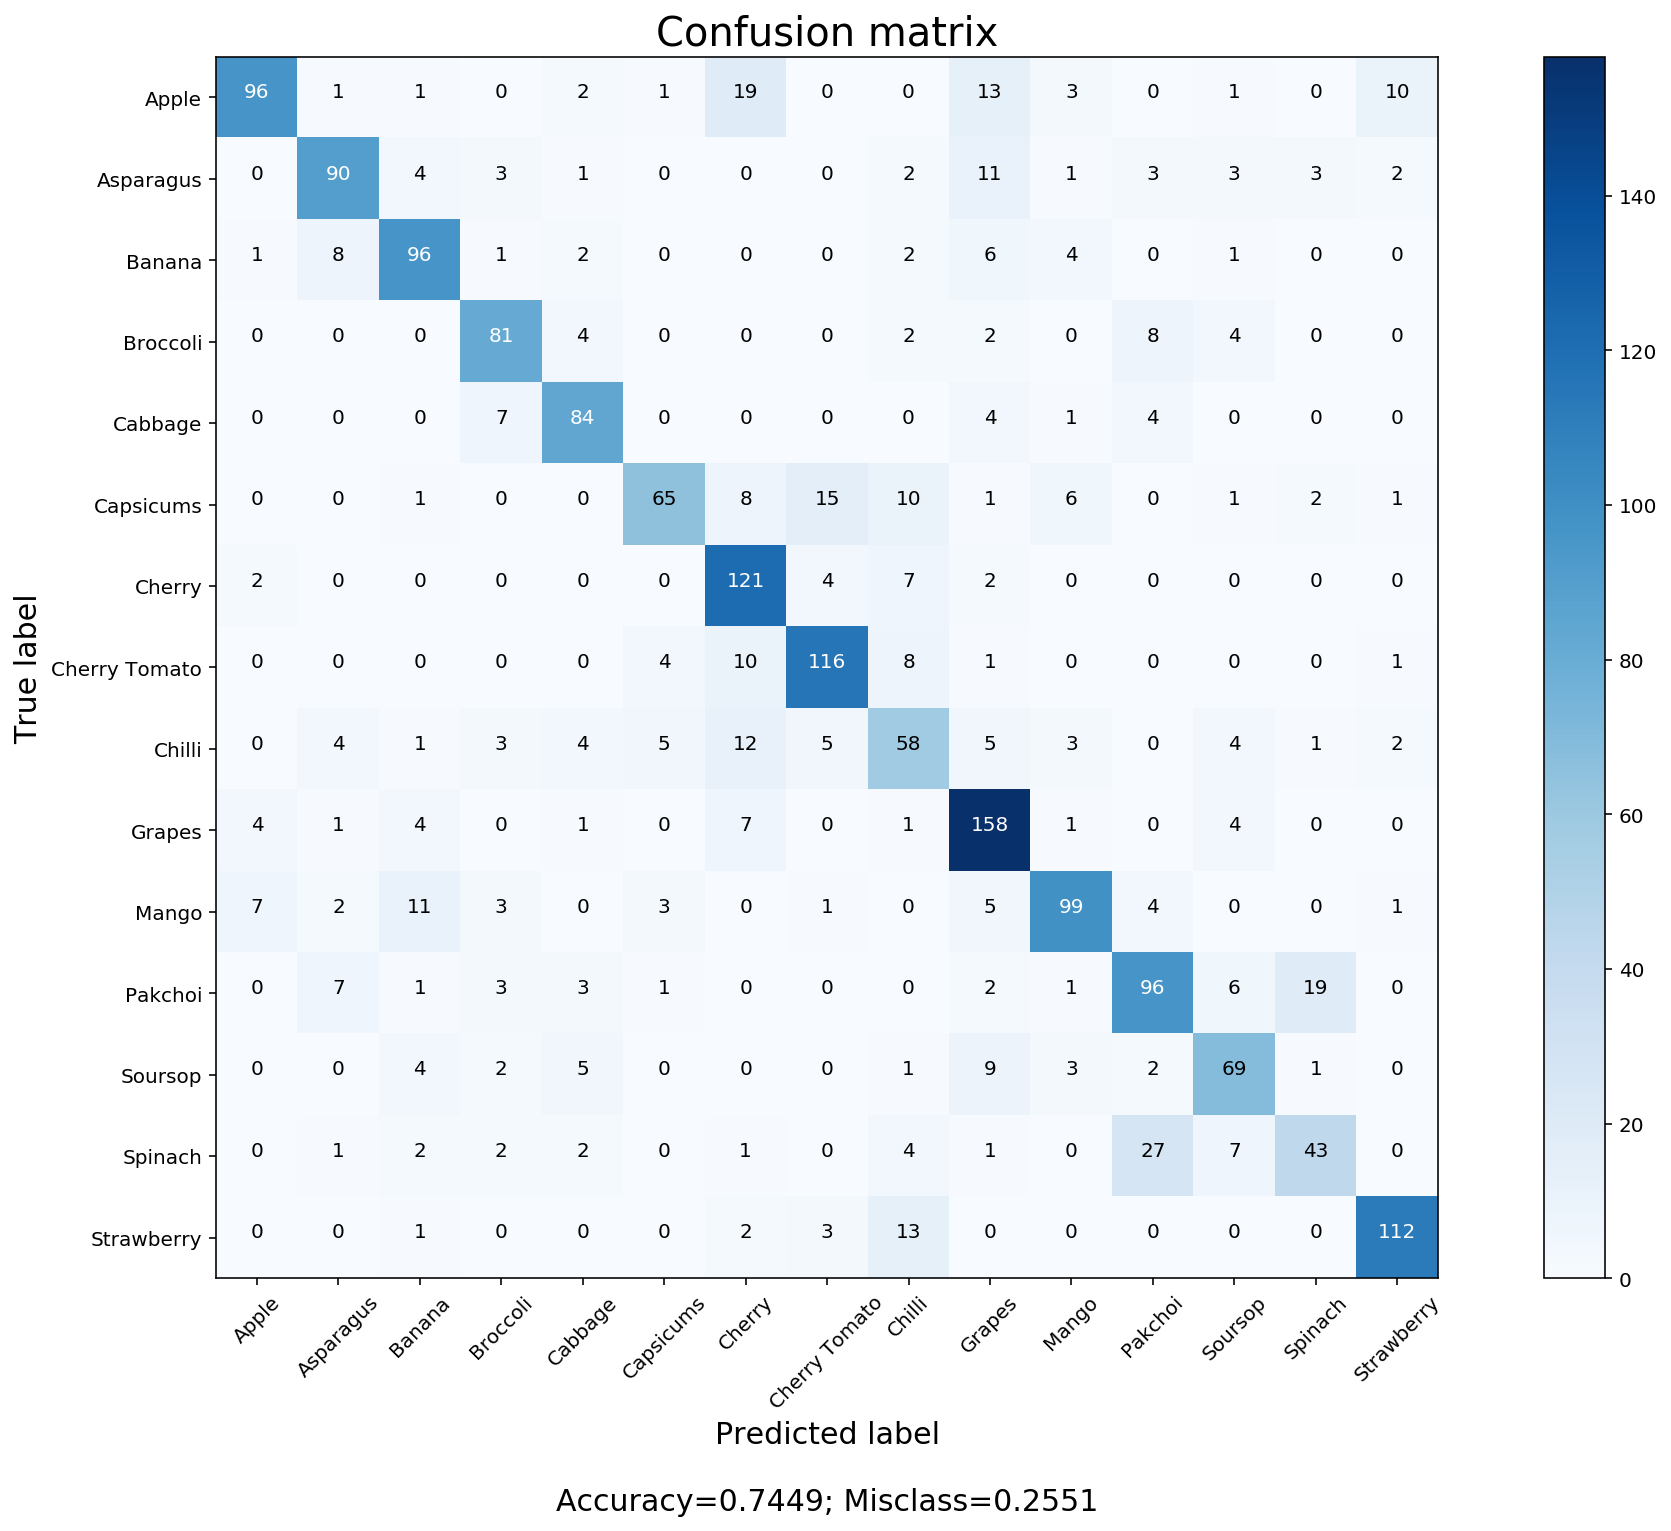

In [10]:
plot_confusion_matrix(confusion_matrix(true_labels, predictions), target_names=target_names)

In [11]:
print(classification_report(true_labels, predictions, target_names=target_names))

               precision    recall  f1-score   support

        Apple       0.87      0.65      0.75       147
    Asparagus       0.79      0.73      0.76       123
       Banana       0.76      0.79      0.78       121
     Broccoli       0.77      0.80      0.79       101
      Cabbage       0.78      0.84      0.81       100
    Capsicums       0.82      0.59      0.69       110
       Cherry       0.67      0.89      0.77       136
Cherry Tomato       0.81      0.83      0.82       140
       Chilli       0.54      0.54      0.54       107
       Grapes       0.72      0.87      0.79       181
        Mango       0.81      0.73      0.77       136
      Pakchoi       0.67      0.69      0.68       139
      Soursop       0.69      0.72      0.70        96
      Spinach       0.62      0.48      0.54        90
   Strawberry       0.87      0.85      0.86       131

  avg / total       0.75      0.74      0.74      1858



### Top 3 error rate

In [12]:
def top_3_class_predictor(test_data, model):
    predictions = []
    for i in range(len(test_data)):
        result_proba = model.predict(test_data[i])
        top_3 = heapq.nlargest(3, range(len(result_proba[0])), result_proba[0].take)
        predictions.append(top_3)
    
    return predictions

In [15]:
top3_predictions = top_3_class_predictor(test_data, loaded_model)

In [17]:
true_in_top3pred = []

for i in range(len(test_data)):
    if true_labels[i] in top3_predictions[i]:
        true_in_top3pred.append(true_labels[i])
    else:
        true_in_top3pred.append(top3_predictions[i][0])

In [18]:
print(classification_report(true_labels, true_in_top3pred, target_names=target_names))

               precision    recall  f1-score   support

        Apple       1.00      0.97      0.99       147
    Asparagus       0.98      0.92      0.95       123
       Banana       0.94      0.96      0.95       121
     Broccoli       0.91      0.90      0.91       101
      Cabbage       0.94      0.97      0.96       100
    Capsicums       0.98      0.92      0.95       110
       Cherry       0.94      0.97      0.95       136
Cherry Tomato       0.96      0.96      0.96       140
       Chilli       0.89      0.92      0.90       107
       Grapes       0.91      0.98      0.95       181
        Mango       0.96      0.94      0.95       136
      Pakchoi       0.95      0.92      0.93       139
      Soursop       0.87      0.95      0.91        96
      Spinach       0.96      0.91      0.94        90
   Strawberry       0.98      0.95      0.97       131

  avg / total       0.95      0.95      0.95      1858



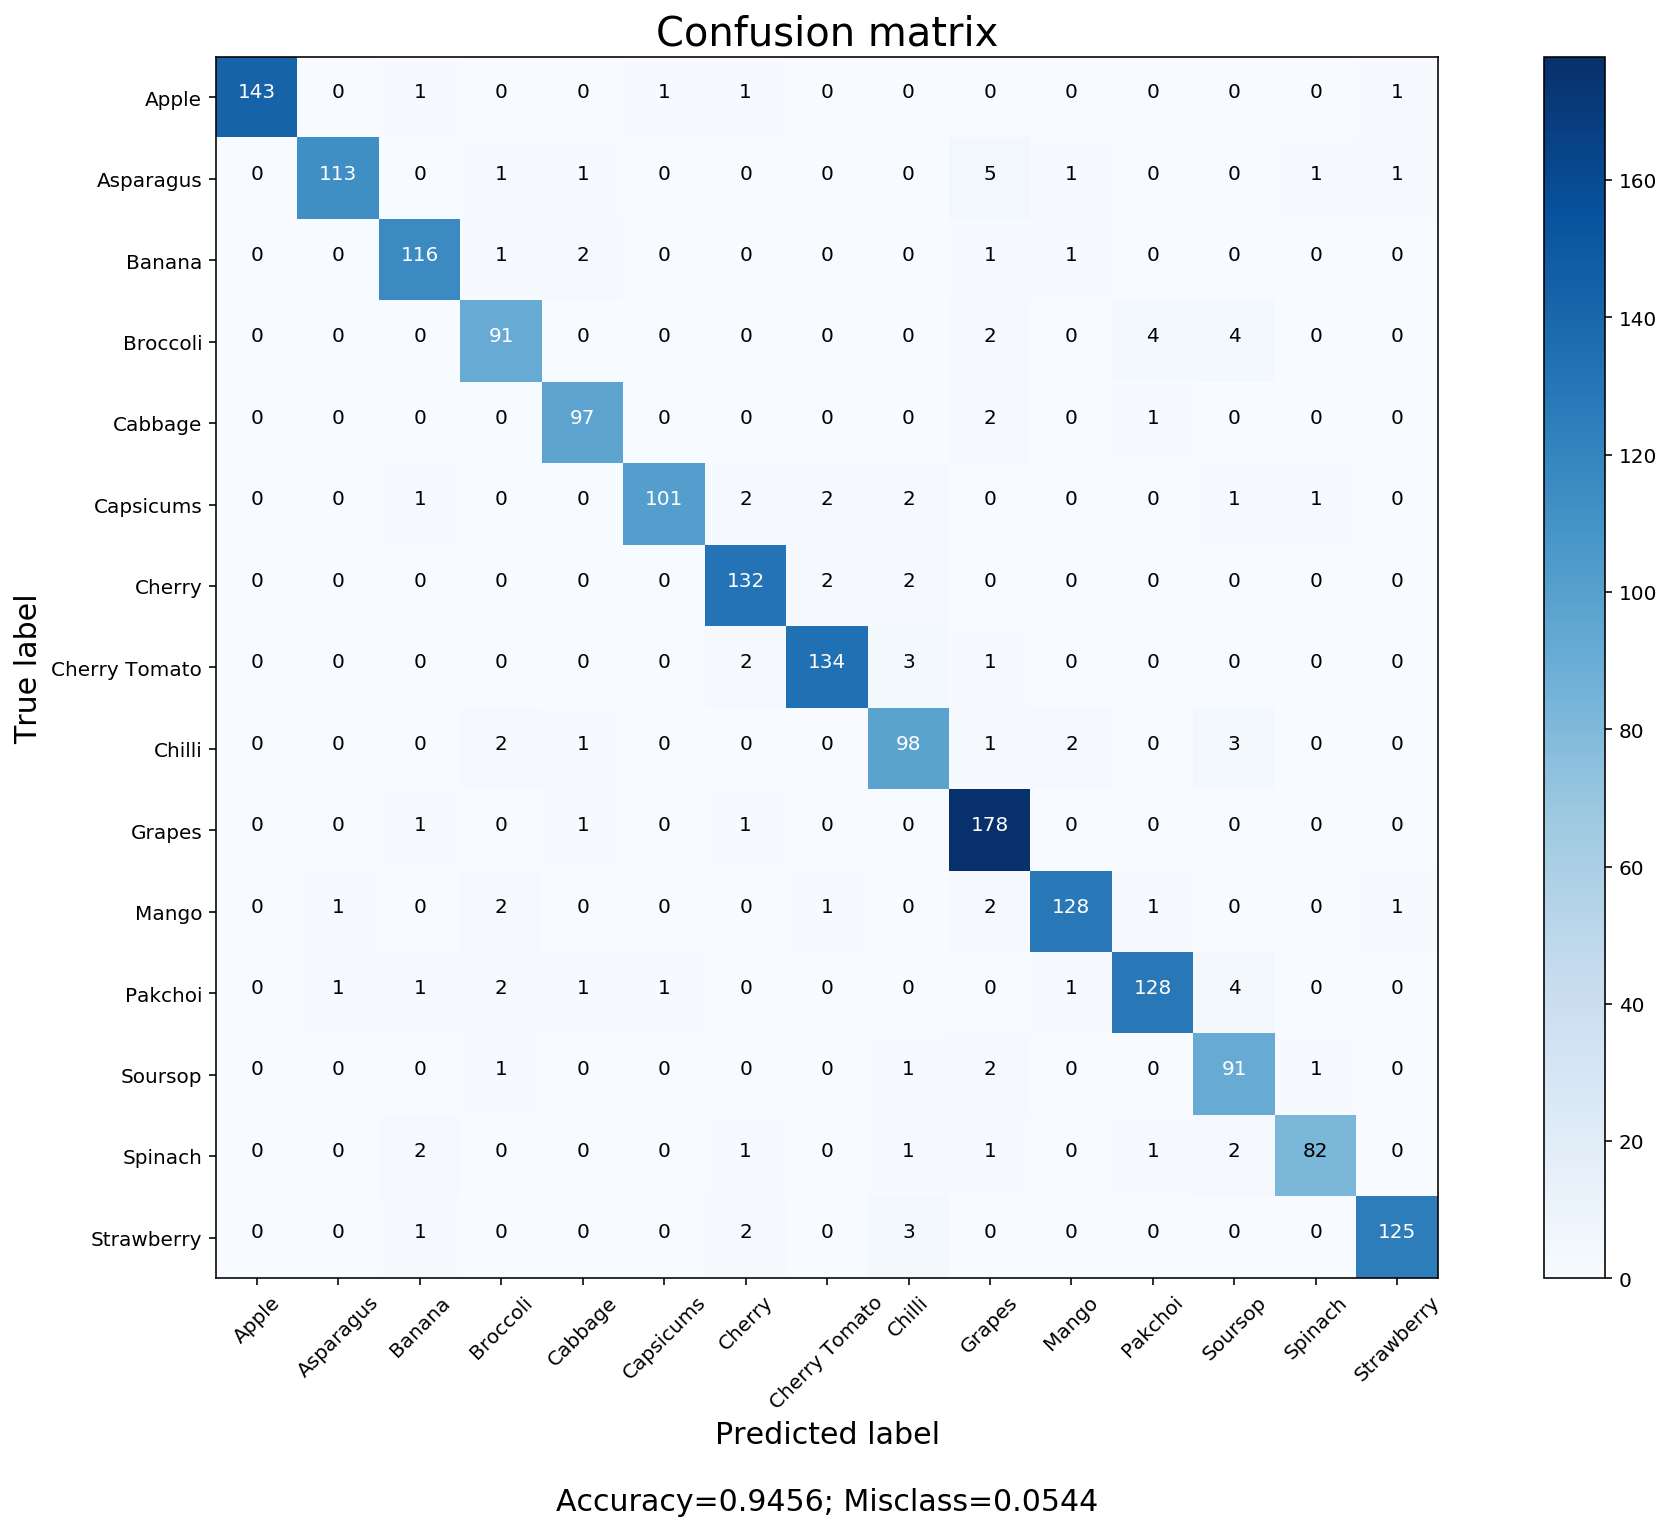

In [19]:
plot_confusion_matrix(confusion_matrix(true_labels, true_in_top3pred), target_names=target_names)